### ML Approach  
Using ML to predict chance of booking, then ranking according to the probability. 


In [90]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
from random import sample
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.decomposition import PCA
from sklearn import metrics
from imblearn.combine import SMOTETomek
from IPython.display import Image  
from datetime import datetime

from proj_fns import preprocess_step

In [91]:
# Verify its using version == 0.23.1, to ensure compatable with imblearn
import sklearn
sklearn.__version__

'0.23.1'

### Preprocessing / Feature engineering

0. Remove unique identifier (search id)
1. Remove Long & lat explained by destination id (high corr)
2. a) Take out 'srch_visitor_wr_member' because 57% missing, or b) split out info in 'srch_visitor_wr_member'
3. Bucket 'srch_ci'
4. remove 'price_without_discount_local' & 'price_with_discount_local', only keep USD version of price to be comparible
5. Subset to only 'booking_bool' True? or resample to increase true & decrease false? ***
6. Most common checkin month from 'srch_ci'
7. Weekday vs weekend checkin fom srch_ci_day *
8. Split price - prop_price_without_discount_usd - into bands

In [145]:
train_raw = pd.read_csv("data/train.csv")
train_raw.shape

(841115, 47)

In [146]:
train_preprocessed = preprocess_step(train_raw)
train_preprocessed.shape

KeyboardInterrupt: 

In [ ]:
train_preprocessed.head()

In [17]:
train_preprocessed.to_csv('data/train_preprocessed.csv', header=True, index=False)

### Train / Test 

In [179]:
train_preprocessed = pd.read_csv('data/train_preprocessed.csv')

In [180]:
# Randomly, split the data into test/training/validation sets
x = train_preprocessed.drop(['prop_booking_bool'], axis=1)
y = train_preprocessed['prop_booking_bool']

x_train, x_test, y_train, y_test  = train_test_split(x, y, test_size=0.33, random_state=42)
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(563547, 59) (277568, 59) (563547,) (277568,)


In [181]:
# Check the balance of the splits on y
print(y_test.mean(), y_train.mean())

0.028241728153101223 0.02870035684690008


In [127]:
# Variable importance from Random Forest (could try PCA instead?)
rf = RandomForestClassifier()
rf.fit(x_train, y_train)

RandomForestClassifier()

In [128]:
feature_importances = sorted(zip(map(lambda x: round(x, 4), rf.feature_importances_), x_train), reverse=True)
feature_importances = pd.DataFrame(feature_importances[:20])
feature_importances

,0,1
0,0.1017,prop_price_with_discount_usd
1,0.0982,prop_review_count
2,0.0837,srch_hour
3,0.0713,srch_visitor_visit_nbr
4,0.0660,prop_discount
5,0.0556,srch_bw_weeks
6,0.0436,prop_key
7,0.0427,prop_room_capacity
8,0.0410,srch_ci_day
9,0.0402,srch_co_day


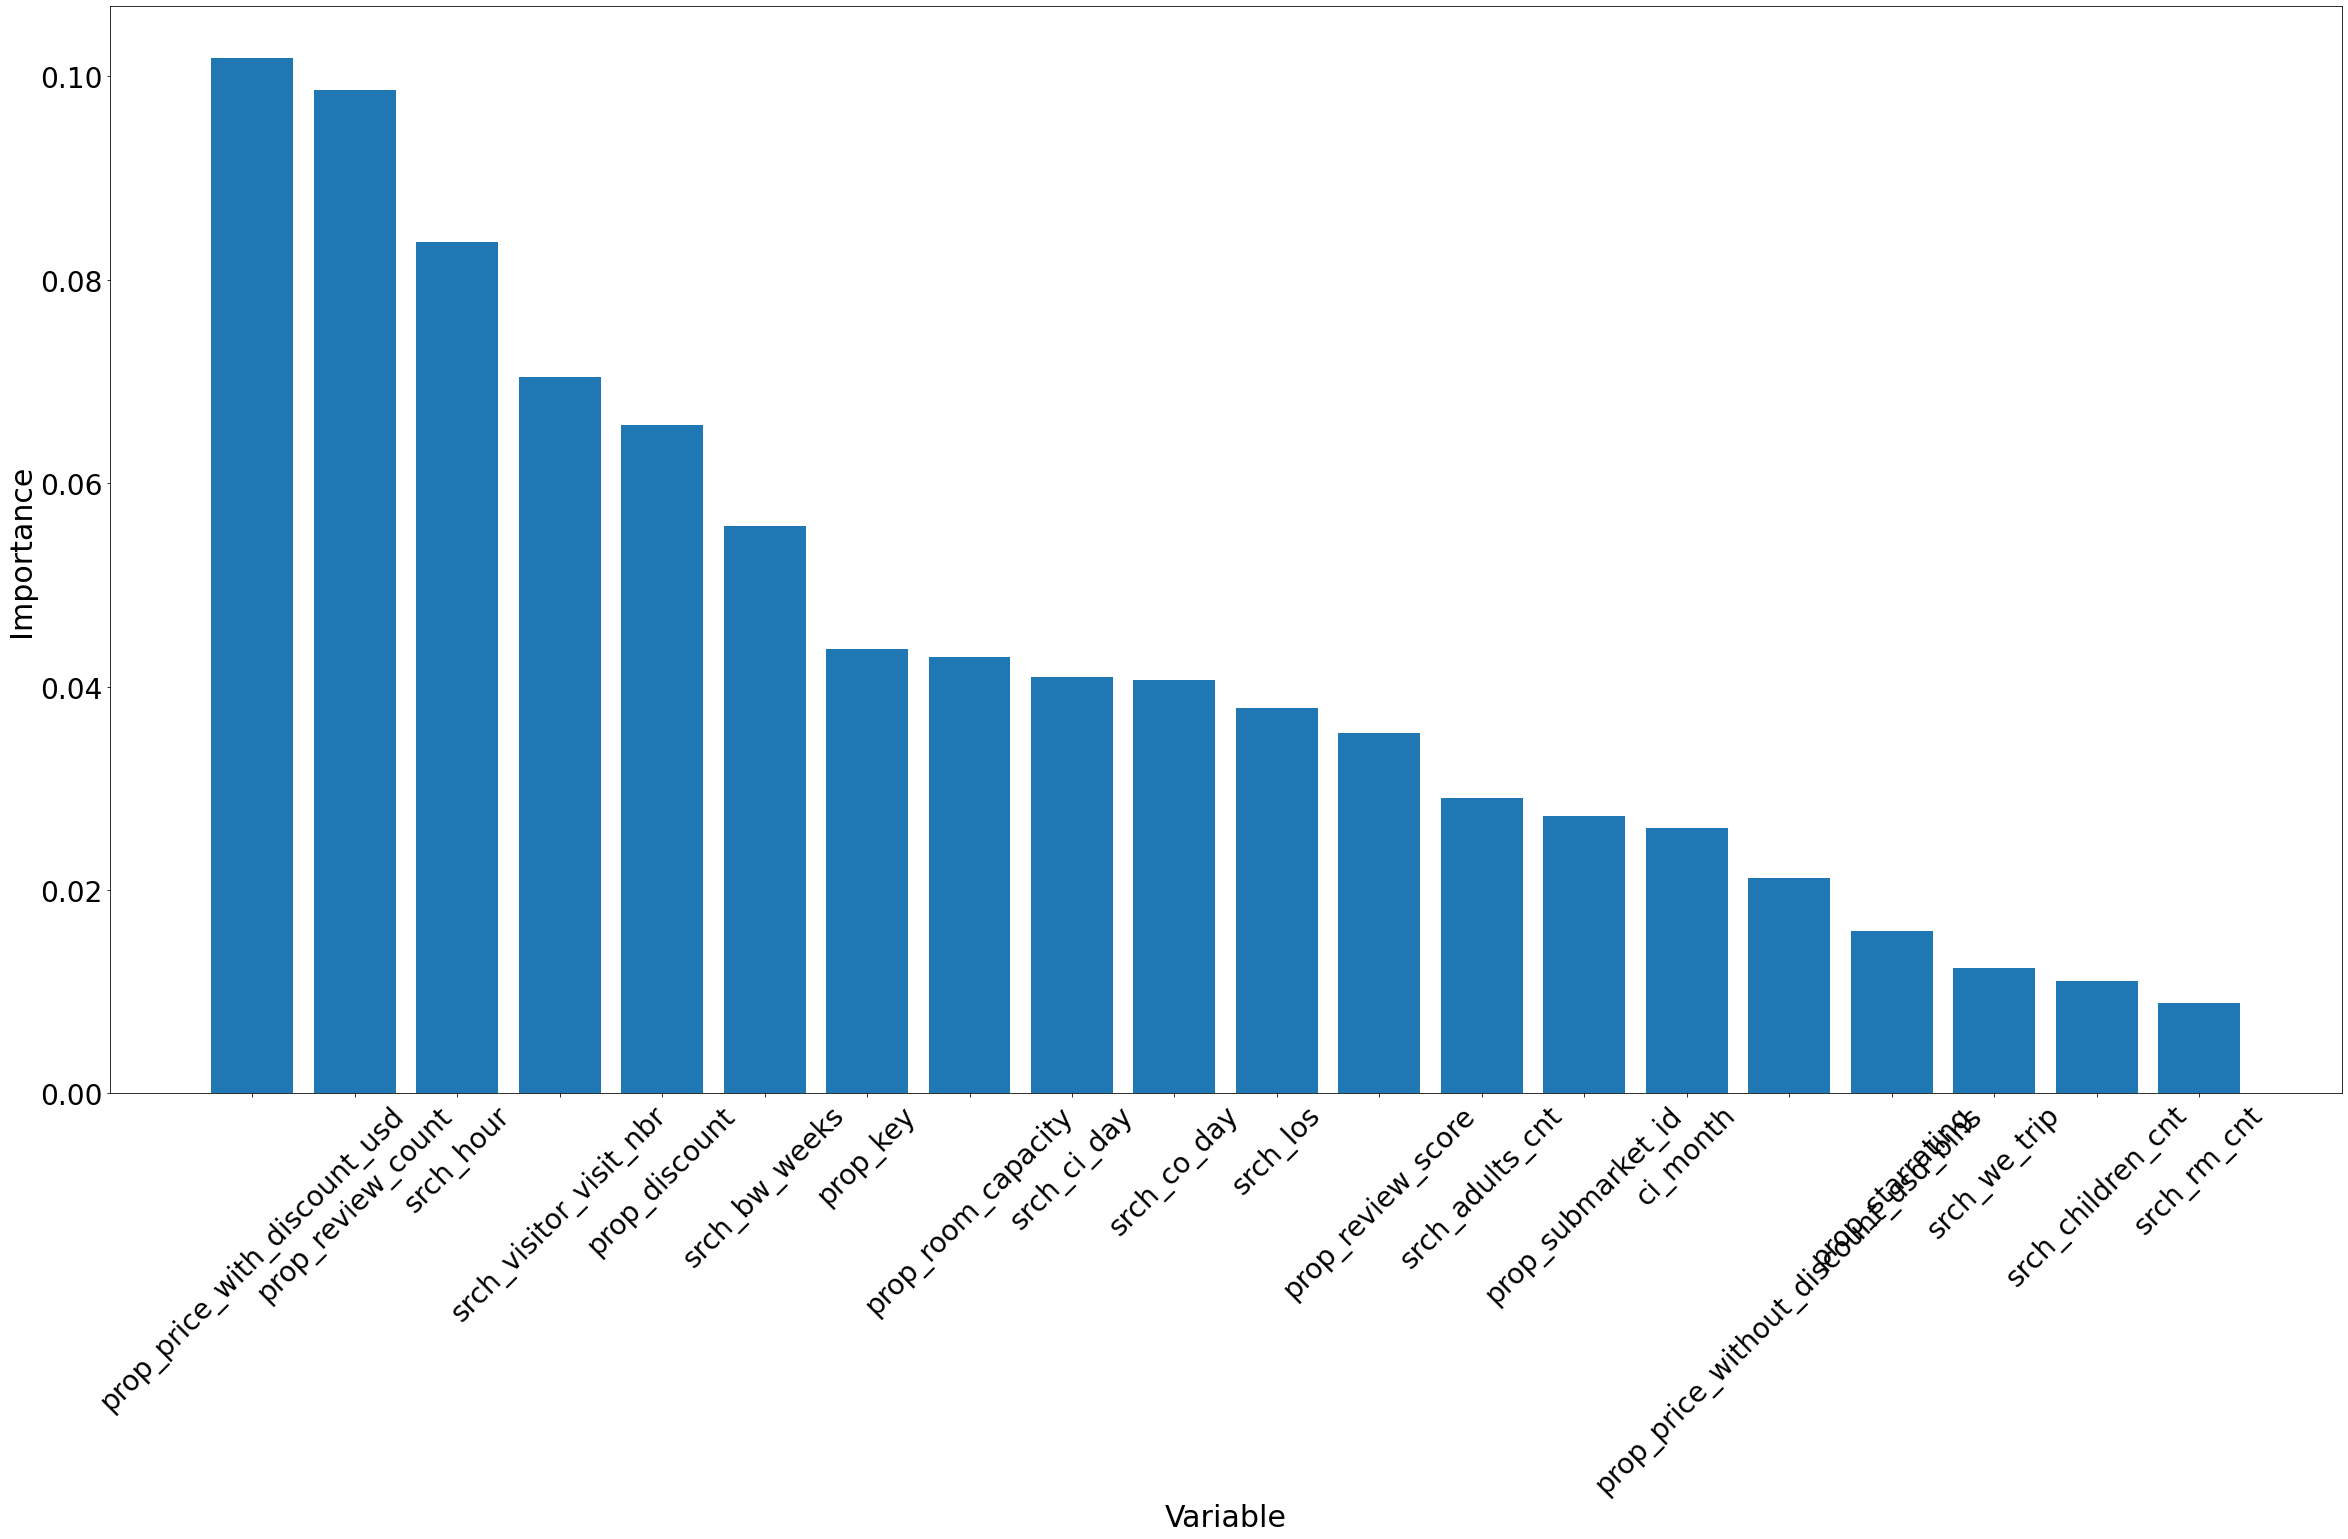

In [8]:
plt.rcParams['font.size'] = '28'
plt.figure(figsize=(40,20))
plt.xticks(rotation=45)
plt.bar(feature_importances[1], feature_importances[0])
plt.xlabel('Variable', fontsize=30)
plt.ylabel('Importance', fontsize=30)
plt.show()

In [150]:
# Take top 12 variables, 
top_12_feats = feature_importances.iloc[:12, 1].tolist()
pd.Series(top_12_feats).to_csv("models/top_12_feats.csv")

In [188]:
# Redefine model input variables, using only top 12
x_train, x_test = x_train[top_12_feats], x_test[top_12_feats]

In [189]:
x_train.head()

,prop_price_with_discount_usd,prop_review_count,srch_hour,srch_visitor_visit_nbr,prop_discount,srch_bw_weeks,prop_key,prop_room_capacity,srch_ci_day,srch_co_day,srch_los,prop_review_score
780096,249.00,181.0,7,32,100.0,3,294558,1000,6,1,2,4.4
788345,102.42,272.0,19,1,31.0,1,988110,41,5,1,3,3.6
779736,419.00,556.0,16,2,100.0,0,272312,155,2,3,1,4.4
328752,78.10,688.0,6,8,63.0,3,3222046,198,3,5,2,3.9
808007,419.00,1023.0,10,9,67.0,6,248955,347,7,3,3,4.4


### Resampling

Over and under sampling - using SMOTE and Tomek links. 

SMOTE (Synthetic Minority Oversampling TEchnique) consists of synthesizing elements for the minority class. 

Tomek links are pairs of very close instances, but of opposite classes. Removing the instances of the majority class of each pair increases the space between the two classes.


In [109]:
def plot_2d_space(X, y, label='Classes'):   
    colors = ['#1F77B4', '#FF7F0E']
    markers = ['o', 's']
    for l, c, m in zip(np.unique(y), colors, markers):
        plt.scatter(
            X[y==l, 0],
            X[y==l, 1],
            c=c, label=l, marker=m
        )
    plt.title(label)
    plt.legend(loc='upper right')
    plt.show()

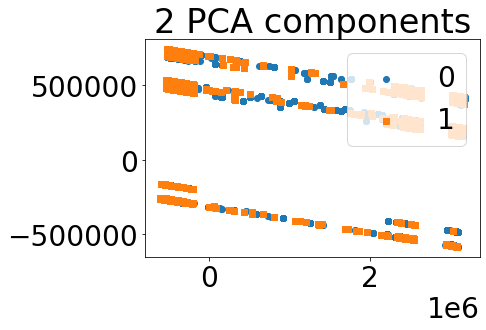

In [16]:
# Use PCA to reduce components down to two, for plotting 
pca = PCA(n_components=2)
x_pca = pca.fit_transform(x)

plot_2d_space(x_pca, y, '2 PCA components')

In [17]:
import sklearn
sklearn.__version__

'0.23.1'

In [161]:
# Over and under sampling - using the SMOTE and Tomek links
# SMOTE (Synthetic Minority Oversampling TEchnique) consists of synthesizing elements for the minority class
# Tomek links are pairs of very close instances, but of opposite classes. Removing the instances of the majority 
# class of each pair increases the space between the two classes

smt = SMOTETomek(random_state=42)
X_smt, y_smt = smt.fit_sample(x_train, y_train)

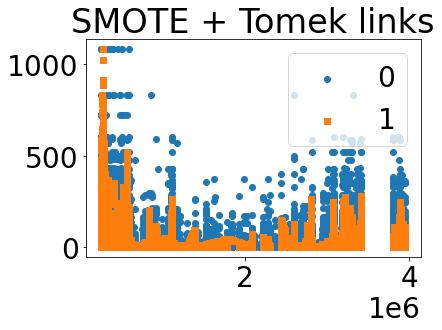

In [110]:
plot_2d_space(np.array(X_smt), np.array(y_smt), 'SMOTE + Tomek links')

In [20]:
# from imblearn.over_sampling import SMOTE

# smote = SMOTE(sampling_strategy='minority')
# x_sm, y_sm = smote.fit_sample(x, y)

# plot_2d_space(x_sm, y_sm, 'SMOTE over-sampling')

In [21]:
# from imblearn.under_sampling import ClusterCentroids

# cc = ClusterCentroids(ratio={0: 10})
# x_cc, y_cc = cc.fit_sample(x, y)

# plot_2d_space(x_cc, y_cc, 'Cluster Centroids under-sampling')

In [162]:
# Randomly, split the resampled data into test/training sets

x_train, y_train  = X_smt.copy(), y_smt.copy()
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(1088806, 59) (277568, 59) (1088806,) (277568,)


In [163]:
# Check the balance of the splits on y
print(y_test.mean(), y_train.mean())

0.028241728153101223 0.5


### Modelling 

1. Logistic regression
2. Random Forest
3. SVM
4. XGBoost 

##### LOGISTIC REGRESSION 

In [45]:
# Instantiate
lr_model = LogisticRegression()
# Fit
lr_model = lr_model.fit(x_train, y_train)
# How accurate?
lr_model.score(x_train, y_train)

0.5607559400010289

In [46]:
# Predictions on the test dataset
predicted = pd.DataFrame(lr_model.predict(x_test))
# Probabilities on the test dataset
probs = pd.DataFrame(lr_model.predict_proba(x_test))
print(metrics.accuracy_score(y_test, predicted))

0.7258401544846668


In [47]:
# Store metrics
logit_accuracy = metrics.accuracy_score(y_test, predicted)
logit_roc_auc = metrics.roc_auc_score(y_test, probs[1])
logit_confus_matrix = metrics.confusion_matrix(y_test, predicted)
logit_classification_report = metrics.classification_report(y_test, predicted)
logit_precision = metrics.precision_score(y_test, predicted, pos_label=1)
logit_recall = metrics.recall_score(y_test, predicted, pos_label=1)
logit_f1 = metrics.f1_score(y_test, predicted, pos_label=1)

In [48]:
print(metrics.confusion_matrix(y_test, predicted))

[[198528  71201]
 [  4897   2942]]


In [49]:
print(metrics.classification_report(y_test, predicted))

              precision    recall  f1-score   support

           0       0.98      0.74      0.84    269729
           1       0.04      0.38      0.07      7839

    accuracy                           0.73    277568
   macro avg       0.51      0.56      0.46    277568
weighted avg       0.95      0.73      0.82    277568



##### RANDOM FOREST

At least this one predicts some sales!

In [164]:
# Instantiate
rf = RandomForestClassifier()    
# Fit
rf_model = rf.fit(x_train, y_train)
# training accuracy 
rf_model.score(x_train, y_train)

0.9999696915703992

In [165]:
# Predictions/probs on the test dataset
predicted = pd.DataFrame(rf_model.predict(x_test))
probs = pd.DataFrame(rf_model.predict_proba(x_test))

In [166]:
# Store metrics
allvars_rf_accuracy = metrics.accuracy_score(y_test, predicted)
allvars_rf_roc_auc = metrics.roc_auc_score(y_test, probs[1])
allvars_rf_confus_matrix = metrics.confusion_matrix(y_test, predicted)
allvars_rf_classification_report = metrics.classification_report(y_test, predicted)
allvars_rf_precision = metrics.precision_score(y_test, predicted, pos_label=1)
allvars_rf_recall = metrics.recall_score(y_test, predicted, pos_label=1)
allvars_rf_f1 = metrics.f1_score(y_test, predicted, pos_label=1)

In [167]:
print(f"rf_confus_matrix: \n{rf_confus_matrix}",
     f"rf_classification_report: \n{rf_classification_report}\n")

rf_confus_matrix: 
[[268619   1110]
 [  7661    178]] rf_classification_report: 
              precision    recall  f1-score   support

           0       0.97      1.00      0.98    269729
           1       0.14      0.02      0.04      7839

    accuracy                           0.97    277568
   macro avg       0.56      0.51      0.51    277568
weighted avg       0.95      0.97      0.96    277568




In [168]:
# Evaluate the model using 10-fold cross-validation
allvars_rf_cv_scores = cross_val_score(RandomForestClassifier(), x_test, y_test, scoring='precision', cv=10)
allvars_rf_cv_mean = np.mean(rf_cv_scores)

In [169]:
print(allvars_rf_cv_mean)

0.4032692307692307


##### SVM

In [56]:
# # SVM is VERY comput instensive, so scale inputs to reduce burden & time
# from sklearn.preprocessing import MinMaxScaler

# scaling = MinMaxScaler(feature_range=(-1,1)).fit(x_train)
# x_train = scaling.transform(x_train)
# x_test = scaling.transform(x_test)

In [57]:
# Instantiate
# svm_model = SVC(probability=True)
# # Fit
# svm_model = svm_model.fit(x_train, y_train)
# # Accuracy
# svm_model.score(x_train, y_train)

In [58]:
# # Predictions/probs on the test dataset
# predicted = pd.DataFrame(svm_model.predict(x_test))
# probs = pd.DataFrame(svm_model.predict_proba(x_test))

In [59]:
# # Store metrics
# svm_accuracy = metrics.accuracy_score(y_test, predicted)
# svm_roc_auc = metrics.roc_auc_score(y_test, probs[1])
# svm_confus_matrix = metrics.confusion_matrix(y_test, predicted)
# svm_classification_report = metrics.classification_report(y_test, predicted)
# svm_precision = metrics.precision_score(y_test, predicted, pos_label=1)
# svm_recall = metrics.recall_score(y_test, predicted, pos_label=1)
# svm_f1 = metrics.f1_score(y_test, predicted, pos_label=1)

In [60]:
# print(f"svm_confus_matrix : {svm_confus_matrix}")

In [61]:
# # Evaluate the model using 10-fold cross-validation
# svm_cv_scores = cross_val_score(SVC(probability=True), x_test, y_test, scoring='precision', cv=10)
# svm_cv_mean = np.mean(svm_cv_scores) 

In [62]:
# print(svm_cv_mean)

##### XGB 

In [190]:
from xgboost import XGBClassifier
# Instantiate 
xgb_model = XGBClassifier(random_state=42)
# Fit
xgb_model = xgb_model.fit(x_train, y_train)
# Accuracy
xgb_model.score(x_train, y_train)

/Users/tabithajohnston/opt/anaconda3/envs/expedia_kaggle/lib/python3.6/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:10:00] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


0.9715764612357088

In [191]:
# Predictions/probs on the test dataset
predicted = pd.DataFrame(xgb_model.predict(x_test))
probs = pd.DataFrame(xgb_model.predict_proba(x_test))

In [192]:
# Store metrics
xgb_accuracy = metrics.accuracy_score(y_test, predicted)
xgb_roc_auc = metrics.roc_auc_score(y_test, probs[1])
xgb_confus_matrix = metrics.confusion_matrix(y_test, predicted)
xgb_classification_report = metrics.classification_report(y_test, predicted)
xgb_precision = metrics.precision_score(y_test, predicted, pos_label=1)
xgb_recall = metrics.recall_score(y_test, predicted, pos_label=1)
xgb_f1 = metrics.f1_score(y_test, predicted, pos_label=1)

In [193]:
print(f"xgb_confus_matrix : \n{xgb_confus_matrix}")

xgb_confus_matrix : 
[[269687     42]
 [  7817     22]]


In [198]:
# Evaluate the model using 10-fold cross-validation
xgb_cv_scores = cross_val_score(xgb_model, x_test, y_test, scoring='precision', cv=10)
xgb_cv_mean = np.mean(xgb_cv_scores)

In [199]:
print(vars12_xgb_cv_mean_nosampling)

0.25726190476190475


##### KNN

In [69]:
# instantiate learning model (k = 3)
knn_model = KNeighborsClassifier(n_neighbors=3)
# fit the model
knn_model.fit(x_train, y_train)
# Accuracy
knn_model.score(x_train, y_train)

0.9647026508609603

In [70]:
# Predictions/probs on the test dataset
predicted = pd.DataFrame(knn_model.predict(x_test))
probs = pd.DataFrame(knn_model.predict_proba(x_test))

In [71]:
# Store metrics
knn_accuracy = metrics.accuracy_score(y_test, predicted)
knn_roc_auc = metrics.roc_auc_score(y_test, probs[1])
knn_confus_matrix = metrics.confusion_matrix(y_test, predicted)
knn_classification_report = metrics.classification_report(y_test, predicted)
knn_precision = metrics.precision_score(y_test, predicted, pos_label=1)
knn_recall = metrics.recall_score(y_test, predicted, pos_label=1)
knn_f1 = metrics.f1_score(y_test, predicted, pos_label=1)

In [72]:
print(knn_confus_matrix)

[[236066  33663]
 [  5641   2198]]


In [73]:
# Evaluate the model using 10-fold cross-validation
knn_cv_scores = cross_val_score(KNeighborsClassifier(n_neighbors=3), x_test, y_test, scoring='precision', cv=10)
knn_cv_mean = np.mean(knn_cv_scores)

In [74]:
print(knn_cv_mean)

0.13330313229589058


##### Two Class Bayes

In [75]:
# Instantiate
bayes_model = GaussianNB()
# Fit the model
bayes_model.fit(x_train, y_train)
# Accuracy
bayes_model.score(x_train, y_train)

0.565866398665383

In [76]:
# Predictions/probs on the test dataset
predicted = pd.DataFrame(bayes_model.predict(x_test))
probs = pd.DataFrame(bayes_model.predict_proba(x_test))

In [77]:
# Store metrics
bayes_accuracy = metrics.accuracy_score(y_test, predicted)
bayes_roc_auc = metrics.roc_auc_score(y_test, probs[1])
bayes_confus_matrix = metrics.confusion_matrix(y_test, predicted)
bayes_classification_report = metrics.classification_report(y_test, predicted)
bayes_precision = metrics.precision_score(y_test, predicted, pos_label=1)
bayes_recall = metrics.recall_score(y_test, predicted, pos_label=1)
bayes_f1 = metrics.f1_score(y_test, predicted, pos_label=1)

In [78]:
# Evaluate the model using 10-fold cross-validation
bayes_cv_scores = cross_val_score(KNeighborsClassifier(n_neighbors=3), x_test, y_test, scoring='precision', cv=10)
bayes_cv_mean = np.mean(bayes_cv_scores)

In [79]:
print(f"bayes_cv_mean: {bayes_cv_mean}")

bayes_cv_mean: 0.13330313229589058


##### Model comparison

In [82]:
# Model comparison
models = pd.DataFrame({
  'Model': ['Logistic', 'r.f.', 'XGB', 'kNN',  'Bayes'],
  'Accuracy' : [logit_accuracy, rf_accuracy, xgb_accuracy, knn_accuracy, bayes_accuracy],
  'Precision': [logit_precision, rf_precision, xgb_precision, knn_precision, bayes_precision],
  'recall' : [logit_recall, rf_recall, xgb_recall, knn_recall, bayes_recall],
  'F1' : [logit_f1, rf_f1, xgb_f1, knn_f1, bayes_f1],
  'cv_precision' : [0, rf_cv_mean, xgb_cv_mean, knn_cv_mean, bayes_cv_mean]
})

In [83]:
# Print table and sort by test precision
models.sort_values(by='Precision', ascending=False)

,Model,Accuracy,Precision,recall,F1,cv_precision
1,r.f.,0.955506,0.112790,0.083812,0.096165,0.298785
2,XGB,0.931462,0.091878,0.160607,0.116888,0.257262
3,kNN,0.858399,0.061292,0.280393,0.100595,0.133303
0,Logistic,0.725840,0.039680,0.375303,0.071772,0.000000
4,Bayes,0.553983,0.035528,0.565761,0.066858,0.133303


In [84]:
# Print table and sort by test precision
models.sort_values(by='recall', ascending=False)

,Model,Accuracy,Precision,recall,F1,cv_precision
4,Bayes,0.553983,0.035528,0.565761,0.066858,0.133303
0,Logistic,0.725840,0.039680,0.375303,0.071772,0.000000
3,kNN,0.858399,0.061292,0.280393,0.100595,0.133303
2,XGB,0.931462,0.091878,0.160607,0.116888,0.257262
1,r.f.,0.955506,0.112790,0.083812,0.096165,0.298785


In [196]:
# XGB Exploration
# Model comparison
xgb_models = pd.DataFrame({
  'Model': ['12_vars_resampled', 'all_vars_resampled', '12_vars_no_sampling', 'all_vars_no_sampling'],
  'Accuracy' : [xgb_accuracy, allvars_xgb_accuracy, vars12_xgb_accuracy_nosampling, allvars_xgb_accuracy_nosampling],
  'Precision': [xgb_precision, allvars_xgb_precision, vars12_xgb_precision_nosampling, allvars_xgb_precision_nosampling],
  'recall' : [xgb_recall, allvars_xgb_recall, vars12_xgb_recall_nosampling, allvars_xgb_recall_nosampling],
  'F1' : [xgb_f1, allvars_xgb_f1, vars12_xgb_f1_nosampling, allvars_xgb_f1_nosampling],
  'cv_precision' : [xgb_cv_mean, allvars_xgb_cv_mean, vars12_xgb_cv_mean_nosampling, allvars_xgb_cv_mean_nosampling]
})

In [197]:
xgb_models

,Model,Accuracy,Precision,recall,F1,cv_precision
0,12_vars_resampled,0.971686,0.343750,0.002806,0.005568,0.257262
1,all_vars_resampled,0.958126,0.096588,0.057788,0.072312,0.257262
2,12_vars_no_sampling,0.971686,0.343750,0.002806,0.005568,0.257262
3,all_vars_no_sampling,0.971701,0.428571,0.006123,0.012074,0.257262


##### Save models 

In [97]:
# write the models to disk
pickle.dump(rf_model, open("models/rf_model.sav", 'wb'))

In [98]:
pickle.dump(bayes_model, open("models/bayes_model.sav", 'wb'))

In [99]:
pickle.dump(xgb_model, open("models/xgb_model.sav", 'wb'))